<IPython.core.display.Javascript object>


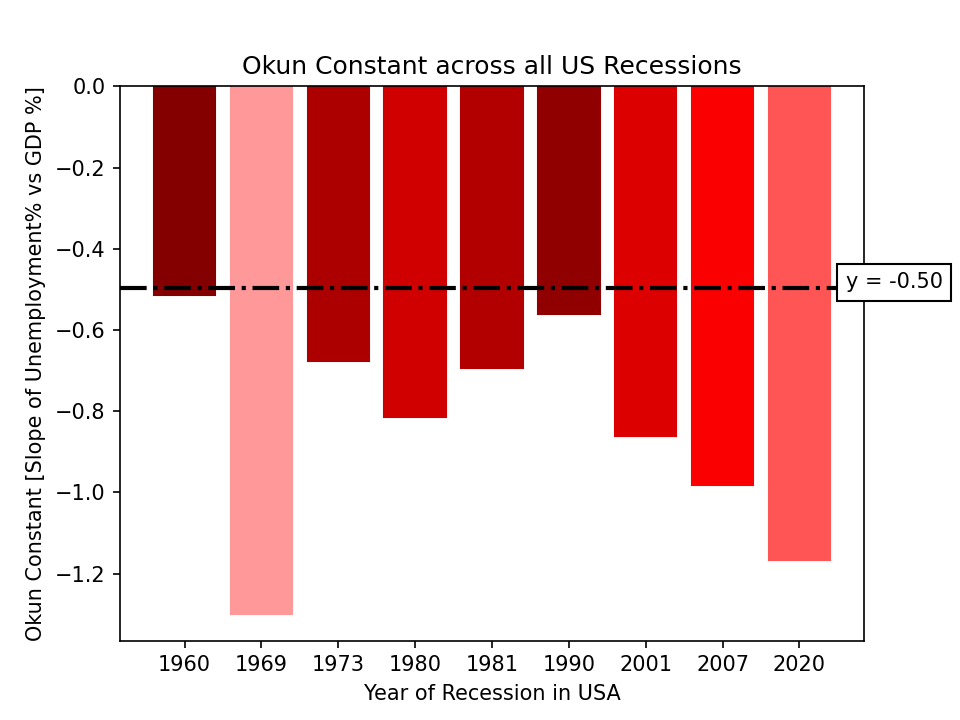

7

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
%matplotlib notebook

#Research Question: In accordance with Okun's law, does a 1% increase in unemployment cause a 2% drop in GDP during a recession in the USA?

#bring in the data
#Both datasets downloaded from FRED (https://fred.stlouisfed.org/)
unemployment_raw = 'https://raw.githubusercontent.com/afsiordia/Coursera-Python/master/UNRATE.csv'
GDP_raw = 'https://raw.githubusercontent.com/afsiordia/Coursera-Python/master/USALORSGPNOSTSAM.csv'
emp = pd.read_csv(unemployment_raw)
gdp = pd.read_csv(GDP_raw)
gdp['USALORSGPNOSTSAM'] = gdp['USALORSGPNOSTSAM']-100

#clean the data
mergedata = pd.merge(gdp, emp)
mergedata = mergedata.set_index(['DATE'])
mergedata = mergedata.rename(columns = {'USALORSGPNOSTSAM': 'GDP Normalized [%]', 'UNRATE' : 'Unemployment Rate [%]'})

gdpempratio = mergedata['Unemployment Rate [%]']/mergedata['GDP Normalized [%]']
ratio = gdpempratio.to_frame().reset_index()
ratio.columns = ['DATE', 'Unemp/GDP']
ratio = ratio.set_index(['DATE'])

mergedatafin = mergedata.join(ratio)

#make series of recession dates and appropraite labels to iterate over
r1960 = mergedatafin['1960-01-01':'1961-02-01']
r1969 = mergedatafin['1969-12-01':'1970-11-01']
r1973 = mergedatafin['1973-11-01':'1975-03-01']
r1980 = mergedatafin['1980-01-01':'1980-07-01']
r1981 = mergedatafin['1981-07-01':'1982-11-01']
r1990 = mergedatafin['1990-07-01':'1991-03-01']
r2001 = mergedatafin['2001-03-01':'2001-11-01']
r2007 = mergedatafin['2007-12-01':'2009-06-01']
r2020 = mergedatafin['2020-02-01':'2020-07-01']

rdata = [r1960, r1969, r1973, r1980, r1981, r1990, r2001, r2007, r2020]
rdatalist = ['1960', '1969', '1973', '1980', '1981', '1990', '2001', '2007', '2020']

#calculate 1st order polynomial slope to compare the GDP to Unemployment ratio
mlist = []
for i in range(len(rdata)):
    m,b = np.polyfit(rdata[i]['GDP Normalized [%]'],rdata[i]['Unemployment Rate [%]'],1)
    mlist.append(m)
    
#form final dataframe for plotting
mlist = pd.DataFrame (mlist, columns = ['Okun Constant'])    
okuncomp = pd.DataFrame(rdatalist, columns = ['Date'])
okuncomp = okuncomp.join(mlist)

y = -1
norm = Normalize(vmin = -2, vmax = 0)
cmap = get_cmap('seismic') #blue to red color range
df_colors = pd.DataFrame([])
#normalize color palette to range of intensities max range
df_colors['intensity'] = norm(okuncomp['Okun Constant']-y)
df_colors['color'] = [cmap(x) for x in df_colors['intensity']]


bar_plot = plt.bar(okuncomp['Date'], okuncomp['Okun Constant'], color = df_colors['color'], capsize = 7)
plt.xlabel("Year of Recession in USA")
plt.ylabel("Okun Constant [Slope of Unemployment% vs GDP %]")
plt.title("Okun Constant across all US Recessions")
#add horizontal line at previous setpoint that will be moved
hz_line = plt.axhline(y = y , color = 'k', linewidth = 2, linestyle = '-.')

# add black border and white fill text box aligned to right side of plot
y_txt = plt.text(8.6, y, 'y = %.2f' %y, bbox = dict(fc = 'white', ec = 'k'))

#setup interaction to view how the constant varies across the years
def onclick(event):
    #for each year normalize the shade w.r.t. standard deviation and set that year to a color intensity
    for i in range(9):
        shade = cmap(norm((okuncomp['Okun Constant'].values[i]-event.ydata)))
        bar_plot[i].set_color(shade)
    #reset the horizontal line to the y value where the event happens
    hz_line.set_ydata(event.ydata)
    #replace the box text to new y axis value and align to right side again
    y_txt.set_text('y = %.2f' %event.ydata)
    y_txt.set_position((8.6, event.ydata))
   
    #plot current figure with interaction(click)
plt.gcf().canvas.mpl_connect('button_press_event', onclick)